In [1]:
import jax
import jax.numpy as jnp
from jax import jit, lax, random, vmap, grad
from jax.config import config 

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from functools import partial
import sys

config.update("jax_debug_nans", True)

In [2]:
def normal_log_prob(x, loc, scale):
    log_unnormalized = -0.5 * (x-loc)**2/scale**2
    log_normalization = 0.5 * np.log(2.*np.pi) + jnp.log(scale)
    return log_unnormalized - log_normalization

def linear_quadratic_two_player(A, B1, B2, Q1, Q2, R11, R12, R21, R22, stop_grad):
    """ Generator for linear state dynamics and quadratic costs. """
    n_state = A.shape[0]
    n_act1 = B1.shape[1]
    n_act2 = B2.shape[1]
    
    assert A.shape[0] == A.shape[1], "A must be square"
    assert B1.shape == (n_state, n_act1), "B1 is in the wrong shape"
    assert B2.shape == (n_state, n_act2), "B2 is in the wrong shape"
    assert R11.shape == (n_act1, n_act1), "R11 is in the wrong shape"
    assert R12.shape == (n_act2, n_act2), "R12 is in the wrong shape"
    assert R21.shape == (n_act1, n_act1), "R21 is in the wrong shape"
    assert R22.shape == (n_act2, n_act2), "R22 is in the wrong shape"
    assert Q1.shape == (n_state, n_state), "Q1 is in the wrong shape"
    assert Q2.shape == (n_state, n_state), "Q2 is in the wrong shape"
    
    K1 = jnp.zeros(B1.shape).T
    K2 = jnp.zeros(B2.shape).T
    
    def state_dynamics(state, rng, policies, act_std1, act_std2):
        K1, K2 = policies
        rng1, rng2 = random.split(rng, 2)
        
        w1 = random.normal(rng1, (n_act1,))
        w2 = random.normal(rng2, (n_act2,))
        
        
        act1 = K1@state + w1*act_std1
        act2 = K2@state + w2*act_std2
        
        if stop_grad:
            act1 = lax.stop_gradient(act1)
            act2 = lax.stop_gradient(act2)
        
        logp1 = normal_log_prob(K1@state, loc=act1, scale=act_std1)
        logp2 = normal_log_prob(K2@state, loc=act2, scale=act_std2)

        state = A@state + B1@act1 + B2@act2 #+ state_std**2*noise

        cost1 = state.T@Q1@state + act1.T@R11@act1 + act2.T@R12@act2
        cost2 = state.T@Q2@state + act1.T@R21@act1 + act2.T@R22@act2
        
        info = dict(state=state,
                    costs=(cost1, cost2), 
                    actions=(act1, act2),
                    logp=(logp1, logp2))
        
        return state, info
    
    return state_dynamics, (K1, K2)


def batch_policy_gradient(dynamics, n_horizon, n_samples, sample_mode):
    """ Two modes supported: exact and logprob """

    def sample_logp(rng, K1, K2, T=n_horizon, **kwargs):
        """ Sample total costs from one trajectory """
        rngs = random.split(rng, T+1)
        x0 = random.normal(rng, (K1.shape[1],))
        _, res = lax.scan(partial(dynamics, policies=(K1, K2), **kwargs), x0, rngs)
        cost1 = lax.stop_gradient(res['costs'][0])
        cost2 = lax.stop_gradient(res['costs'][1])
        logp1 = res['logp'][0]
        logp2 = res['logp'][1]

        return (cost1*logp1).mean(), (cost2*logp2).mean()

    def sample_exact(rng, K1, K2, T=n_horizon, **kwargs):
        """ Sample total costs from one trajectory """
        rngs = random.split(rng, T+1)
        x0 = random.normal(rng, (K1.shape[1],))
        _, res = lax.scan(partial(dynamics, policies=(K1, K2), **kwargs), x0, rngs)
        cost1 = res['costs'][0]
        cost2 = res['costs'][1]

        return cost1.mean(), cost2.mean()

    if sample_mode == 'logprob':
        sample = sample_logp
    elif sample_mode == 'exact':
        sample = sample_exact
    else:
        assert False, "sample mode '{}' not supported".format(sample_mode)

    def samples1(rng, K1, K2, N=n_samples, **kwargs):
        """ Sample average total costs from N trajectories (player 1) """
        rngs = random.split(rng, N)
        loss1, loss2 = vmap(partial(sample, K1=K1, K2=K2, **kwargs))(rngs)
        return loss1.mean()

    def samples2(rng, K1, K2, N=n_samples, **kwargs):
        """ Sample average total costs from N trajectories (player 2) """
        rngs = random.split(rng, N)
        loss1, loss2 = vmap(partial(sample, K1=K1, K2=K2, **kwargs))(rngs)
        return loss2.mean()

    D1f1 = grad(samples1, argnums=1)
    D2f2 = grad(samples2, argnums=2)

    return D1f1, D2f2

def batch_simgrad(game_form, n_iters):
    D1f1, D2f2 = game_form
    
    def simgrad(policies, rng, lr1, lr2, **kwargs):
        K1, K2 = policies
        g1, g2 = D1f1(rng, K1, K2, **kwargs), D2f2(rng, K1, K2, **kwargs)

        K1 = K1 - lr1*g1
        K2 = K2 - lr2*g2

        info = dict(K1=K1, K2=K2, 
            gradnorm1=jnp.linalg.norm(g1), gradnorm2=jnp.linalg.norm(g2))
        return (K1, K2), info

    def multi_step(rng, policies, N=n_iters, **kwargs):
        rngs = random.split(rng, N)
        policies, res = lax.scan(partial(simgrad, **kwargs), policies, rngs)
        return policies, res
    
    return jit(multi_step)

sample_mode = 'exact'
#sample_mode = 'logprob'

I = np.eye(1)
A = 0.9*I
B1, B2 = .2*I, .05*I
Q, R1, R2 = 10*I, 1*I, -.5*I

sys1_zs_params = dict(A=A, B1=B1, B2=B2, Q1=Q, Q2=-Q, 
                      R11=R1, R12=R2, R21=-R1, R22=-R2,
                      stop_grad=sample_mode=='logprob')
batch_pg_params = dict(n_horizon=15, n_samples=32, sample_mode=sample_mode)
batch_simgrad_params = dict(n_iters=32)

state_dynamics, init_profile = linear_quadratic_two_player(**sys1_zs_params)
game_form = batch_policy_gradient(state_dynamics, **batch_pg_params)
multi_step = batch_simgrad(game_form, **batch_simgrad_params)


def save(results, app):
    if results == {}:
        for k in app.keys():
            results[k] = app[k]
    else:
        for k in app.keys():
            results[k] = np.concatenate((results[k], app[k]))

rng = random.PRNGKey(0)
dynam_params = dict(act_std1=.1, act_std2=.1)
learn_params = dict(lr1=1e-4, lr2=1e-4)
print('Compiling...')
%time _ = multi_step(rng, init_profile, **dynam_params, **learn_params)
print('done.')
    

/Users/ben/anaconda3/lib/python3.5/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Compiling...
CPU times: user 21.4 s, sys: 574 ms, total: 21.9 s
Wall time: 22.6 s
done.


In [3]:
seed = 0
n_epoch = 1000
dynam_params = dict(act_std1=.5, act_std2=.1)
learn_params = dict(lr1=1e-4, lr2=1e-4)
K1, K2 = init_profile
policies = K1, K2
        
print('Running [{}] gradient sampling '.format(sample_mode))
rng = random.PRNGKey(seed)
rngs = random.split(rng, n_epoch)
results = dict()
for epoch,rng in enumerate(rngs):
    policies, res = multi_step(rng, policies, **dynam_params, **learn_params)
    sys.stdout.write('\rEpoch: {}/{}'.format(epoch+1, n_epoch))
    save(results, res)

Running [exact] gradient sampling 
Epoch: 1000/1000

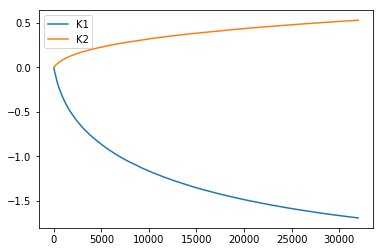

In [4]:
plt.plot(results['K1'].flatten(), label="K1")
plt.plot(results['K2'].flatten(), label="K2")
plt.legend()

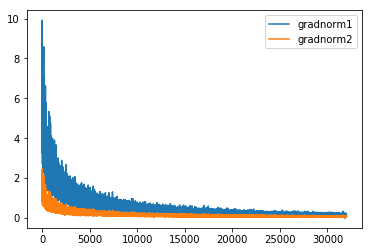

In [5]:
plt.plot(results['gradnorm1'].flatten(), label="gradnorm1")
plt.plot(results['gradnorm2'].flatten(), label="gradnorm2")
plt.legend()

In [7]:
results

{'K1': array([[[-8.0397422e-04]],
 
        [[-1.4888238e-03]],
 
        [[-2.0630346e-03]],
 
        ...,
 
        [[-1.6916076e+00]],
 
        [[-1.6916242e+00]],
 
        [[-1.6916381e+00]]], dtype=float32), 'K2': array([[[2.0002080e-04]],
 
        [[3.7035154e-04]],
 
        [[5.1349035e-04]],
 
        ...,
 
        [[5.3034478e-01]],
 
        [[5.3035134e-01]],
 
        [[5.3035843e-01]]], dtype=float32), 'gradnorm1': array([8.039742  , 6.8484955 , 5.7421083 , ..., 0.1711201 , 0.16589849,
        0.1399479 ], dtype=float32), 'gradnorm2': array([2.0002081 , 1.7033073 , 1.4313879 , ..., 0.07523417, 0.0655235 ,
        0.07092512], dtype=float32)}